In [1]:
import FinanceDataReader as fdr
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
pd.options.display.float_format = '{:,.3f}'.format

### **가설 - 가격 변동성이 크고 거래량이 몰린 종목이 주가가 상승한다.**   
"가격 변동성이 크고 거래량이 몰린 종목이 주가가 상승한다" 라는 가설을 증명하기 위해서는 "가격 변동성이 크다", "거래량이 몰린다" 등을 표현하는 변수가 필요합니다. 먼저 일봉데이터를 불러옵니다.

In [10]:
mdl_data = pd.read_pickle('mdl_data.pkl')
mdl_data.head()

,open,high,low,close,volume,change,code,name,kosdaq_return,return,win_market,close_r1,close_r2,close_r3,close_r4,close_r5,max_close
date,,,,,,,,,,,,,,,,,
2021-01-04,2185,2320,2135,2260,588133,0.044,060310,3S,NaN,NaN,0,0.996,1.013,1.013,0.993,0.962,1.013
2021-01-05,2270,2285,2200,2250,410263,-0.004,060310,3S,1.008,0.996,0,1.018,1.018,0.998,0.967,0.971,1.018
2021-01-06,2225,2310,2215,2290,570349,0.018,060310,3S,0.996,1.018,1,1.000,0.980,0.950,0.954,0.950,1.000
2021-01-07,2290,2340,2240,2290,519777,0.000,060310,3S,1.008,1.000,0,0.980,0.950,0.954,0.950,0.959,0.980
2021-01-08,2300,2315,2225,2245,462568,-0.020,060310,3S,0.999,0.980,0,0.969,0.973,0.969,0.978,0.973,0.978


첫 번째 종목 060310 에 대하여 가격 변동성 변수를 만들어 보겠습니다. 전 5일 종가의 평균(price_mean), 전 5일 종가의 표준편차(price_std)를 먼저 구합니다. 그리고, 전 5일의 평균 및 표준편차 대비 당일 종가의 수준을 표준화해서 보여주는 값이 'price_z' 입니다. price_z 값이 -1.96 와 +1.96 안에 값이면 95% 신뢰구간 안에 들어갑니다. 즉 -1.96 보다 작거나, 1.96 보다 크면(100 번중 5번 미만으로 일어날 확율) 당일의 종가는 직전 5일의 움직임에 비해 아주 특별하다고 생각할 수 있습니다.

In [3]:
df = mdl_data[mdl_data['code']=='060310'].copy() 
df['price_mean'] = df['close'].rolling(5).mean() # 직전 5일 종가의 평균
df['price_std'] = df['close'].rolling(5).std() # 직전 5일 종가의 표준편차
df['price_z'] = (df['close'] - df['price_mean'])/df['price_std'] # 직전 5일 종가의 평균 및 표준편차 대비 오늘 종가의 위치
df[['close','price_mean','price_std','price_z']].head(10)

,close,price_mean,price_std,price_z
date,,,,
2021-01-04,2260,NaN,NaN,NaN
2021-01-05,2250,NaN,NaN,NaN
2021-01-06,2290,NaN,NaN,NaN
2021-01-07,2290,NaN,NaN,NaN
2021-01-08,2245,"2,267.000",21.679,-1.015
2021-01-11,2175,"2,250.000",47.037,-1.594
2021-01-12,2185,"2,237.000",55.295,-0.940
2021-01-13,2175,"2,214.000",51.527,-0.757
2021-01-14,2195,"2,195.000",29.155,0.000


<br> 전 종목에 대하여 동일한 계산을 합니다. 그리고 그 결과를 data_all_7 에 담습니다.

In [4]:
kosdaq_list = pd.read_pickle('kosdaq_list.pkl')

data_all_7 = pd.DataFrame()

for code in kosdaq_list['code']:

    data = mdl_data[mdl_data['code']==code].sort_index().copy()
    data['price_mean'] = data['close'].rolling(20).mean()
    data['price_std'] = data['close'].rolling(20).std(ddof=0)
    data['price_z'] = (data['close'] - data['price_mean'])/data['price_std']    
    
    data['volume_mean'] = data['volume'].rolling(20).mean()
    data['volume_std'] = data['volume'].rolling(20).std(ddof=0)
    data['volume_z'] = (data['volume'] - data['volume_mean'])/data['volume_std']
       
    data['max_close']  = data[['close_r1','close_r2','close_r3','close_r4','close_r5']].max(axis=1) # 5 영업일 종가 수익율 중 최고 값
    data.dropna(subset=['price_z','volume_z','close_r1','close_r2','close_r3','close_r4','close_r5'], inplace=True) # missing 이 있는 행은 제거  
    
    data = data[(data['price_std']!=0) & (data['volume_std']!=0)] # 0 으로 나누는 상황은 없도록 함.
    
    data_all_7 = pd.concat([data, data_all_7], axis=0)

data_all_7.to_pickle('data_all_7.pkl')  

In [5]:
data_all_7 = pd.read_pickle('data_all_7.pkl')  
print(data_all_7['price_z'].agg(['min','max']))
print(data_all_7['volume_z'].agg(['min','max']))

min   -4.359
max    4.359
Name: price_z, dtype: float64
min   -2.568
max    4.359
Name: volume_z, dtype: float64


<AxesSubplot:xlabel='price_z'>

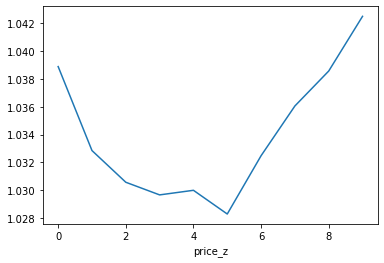

In [7]:
rank = pd.qcut(data_all_7['price_z'], q=10, labels=range(10))
data_all_7.groupby(rank)['max_close'].mean().plot()

<AxesSubplot:xlabel='volume_z'>

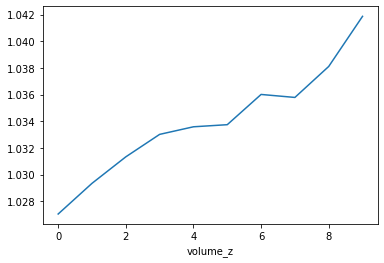

In [8]:
rank = pd.qcut(data_all_7['volume_z'], q=10, labels=range(10))
data_all_7.groupby(rank)['max_close'].mean().plot()

<br> 종가의 표준화 값 price_z 와 거래량의 표준화 값 volume_z 를 서로 직교하는 테이블로 구성하고 평균 수익율을 보니, 가격이 변동성이 높고, 거래량이 몰리는 종목은 평균 수익율이 더 높다는 것이 확인되었습니다.

In [9]:
rank1  = pd.qcut(data_all_7['price_z'], q=5, labels=range(5))
rank2  = pd.qcut(data_all_7['volume_z'], q=5, labels=range(5))

data_all_7.groupby([rank1, rank2])['max_close'].mean().unstack()

volume_z,0,1,2,3,4
price_z,,,,,
0,1.032,1.034,1.035,1.038,1.040
1,1.028,1.029,1.031,1.034,1.035
2,1.026,1.030,1.030,1.029,1.032
3,1.028,1.035,1.035,1.036,1.037
4,1.029,1.038,1.038,1.039,1.044
